In [1]:
import  keras
import  tensorflow as  tf  
print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.1.2
1.5.0


In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


##  Analyze data

In [3]:
# import all stock prices 
df = pd.read_csv("WWWW.csv", index_col = 0)
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, 2015-01-02 to 2018-11-08
Data columns (total 9 columns):
AMOpen      968 non-null float64
AMClose     968 non-null float64
AMHigh      968 non-null float64
AMLow       968 non-null float64
SPHigh      968 non-null float64
SPLow       968 non-null float64
SPClose     968 non-null float64
SPVolume    968 non-null int64
AMVolume    968 non-null int64
dtypes: float64(7), int64(2)
memory usage: 75.6+ KB


,AMOpen,AMClose,AMHigh,AMLow,SPHigh,SPLow,SPClose,SPVolume,AMVolume
Date,,,,,,,,,
2018-11-02,49.020000,48.919998,50.000000,47.029999,15222.9004,15037.2002,15119.2998,268963600,3026701
2018-11-05,48.959999,52.529999,52.779999,47.590000,15242.4004,15136.7998,15217.7002,255477900,4749101
2018-11-06,52.880001,56.139999,57.740002,51.439999,15295.2998,15220.2002,15292.7002,237092100,16835001
2018-11-07,58.150002,60.610001,61.250000,54.090000,15392.0000,15293.2998,15369.4004,271236500,8056401
2018-11-08,58.209999,56.000000,59.200001,55.270000,15393.0996,15293.2998,15357.5000,272717600,5178801


In [4]:
df.iloc[-1,]

AMOpen      5.821000e+01
AMClose     5.600000e+01
AMHigh      5.920000e+01
AMLow       5.527000e+01
SPHigh      1.539310e+04
SPLow       1.529330e+04
SPClose     1.535750e+04
SPVolume    2.727176e+08
AMVolume    5.178801e+06
Name: 2018-11-08, dtype: float64

In [5]:
df.describe()

,AMOpen,AMClose,AMHigh,AMLow,SPHigh,SPLow,SPClose,SPVolume,AMVolume
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,9.680000e+02,9.680000e+02
mean,13.638678,13.638791,14.074391,13.161797,14980.104743,14858.191941,14919.920556,2.105877e+08,2.601801e+06
std,16.305952,16.298493,16.928106,15.605561,998.270174,1026.268973,1009.696847,6.699353e+07,3.503775e+06
min,1.520000,1.510000,1.600000,1.150000,11932.400400,11531.200200,11843.099600,3.785510e+07,1.000000e+00
25%,2.097500,2.100000,2.120000,2.050000,14384.674800,14263.324950,14311.725100,1.739864e+08,1.278260e+05
50%,7.855000,7.825000,8.005000,7.720000,15187.850100,15080.450200,15143.650400,2.020530e+08,1.036351e+06
75%,18.782500,18.782500,19.290000,18.172500,15649.200200,15545.925050,15609.950200,2.321720e+08,3.817526e+06
max,76.000000,73.750000,76.680000,68.110001,16586.500000,16539.199200,16567.400400,8.588881e+08,2.431410e+07


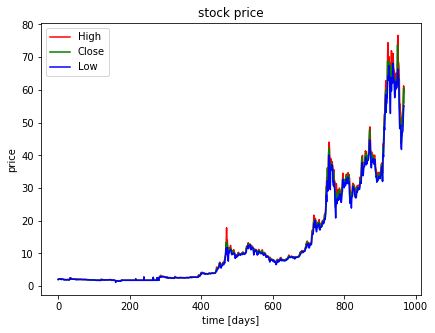

In [6]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.AMHigh.values, color='red', label='High')
plt.plot(df.AMClose.values, color='green', label='Close')
plt.plot(df.AMLow.values, color='blue', label='Low')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

plt.subplot(1,2,2);
plt.plot(df.AMVolume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

## 3. Manipulate data 

In [7]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['AMOpen'] = min_max_scaler.fit_transform(df.AMOpen.values.reshape(-1,1))
    df['AMHigh'] = min_max_scaler.fit_transform(df.AMHigh.values.reshape(-1,1))
    df['AMLow'] = min_max_scaler.fit_transform(df.AMLow.values.reshape(-1,1))
    df['AMClose'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    df['SPHigh'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    df['SPLow'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    df['SPClose'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    df['SPVolume'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    df['AMVolume'] = min_max_scaler.fit_transform(df.AMClose.values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# normalize stock
df_stock_norm = normalize_data(df)

# create train, test data
seq_len = 5 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape) #19*3
print('y_train.shape = ', y_train.shape) #1*3
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


cols = list(df_stock_norm.columns.values)
print('df_stock_norm.columns.values = ', cols)


x_train.shape =  (771, 4, 9)
y_train.shape =  (771, 9)
x_valid.shape =  (96, 4, 9)
y_valid.shape =  (96, 9)
x_test.shape =  (96, 4, 9)
y_test.shape =  (96, 9)
df_stock_norm.columns.values =  ['AMOpen', 'AMClose', 'AMHigh', 'AMLow', 'SPHigh', 'SPLow', 'SPClose', 'SPVolume', 'AMVolume']


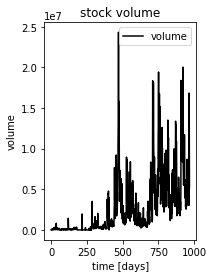

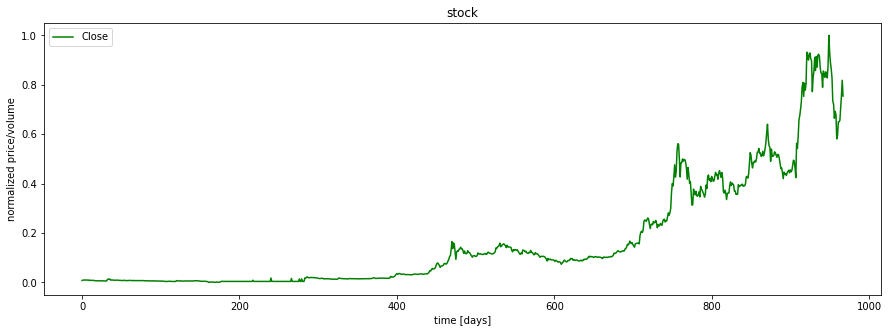

In [8]:
fig= plt.figure(figsize=(15, 5))
plt.plot(df_stock_norm.AMClose.values, color='green', label='Close')
#plt.plot(df_stock_norm.AMLow.values, color='blue', label='Low')
#plt.plot(df_stock_norm.AMHigh.values, color='black', label='High')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

#fig.savefig('plot.png')

## 4. RNN Model and validate data 

In [53]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 9
n_neurons = 3 
n_outputs = 9
n_layers = 2
learning_rate = 0.001
batch_size = 1
n_epochs = 1000
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
                                                             
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    


0.00 epochs: MSE train/valid = 0.064656/0.600589
5.00 epochs: MSE train/valid = 0.000305/0.001000
10.00 epochs: MSE train/valid = 0.000137/0.000706
15.00 epochs: MSE train/valid = 0.000108/0.000549
20.00 epochs: MSE train/valid = 0.000125/0.000828
25.00 epochs: MSE train/valid = 0.000086/0.000401
30.00 epochs: MSE train/valid = 0.000079/0.000369
35.00 epochs: MSE train/valid = 0.000074/0.000404
40.00 epochs: MSE train/valid = 0.000140/0.000775
45.00 epochs: MSE train/valid = 0.000107/0.000600
50.00 epochs: MSE train/valid = 0.000073/0.000418
55.00 epochs: MSE train/valid = 0.000067/0.000366
60.00 epochs: MSE train/valid = 0.000070/0.000386
65.00 epochs: MSE train/valid = 0.000088/0.000644
70.00 epochs: MSE train/valid = 0.000070/0.000411
75.00 epochs: MSE train/valid = 0.000076/0.000441
80.00 epochs: MSE train/valid = 0.000070/0.000415
85.00 epochs: MSE train/valid = 0.000076/0.000452
90.00 epochs: MSE train/valid = 0.000067/0.000350
95.00 epochs: MSE train/valid = 0.000123/0.001295
10

810.00 epochs: MSE train/valid = 0.000062/0.000742
815.00 epochs: MSE train/valid = 0.000081/0.001137
820.00 epochs: MSE train/valid = 0.000081/0.001109
825.00 epochs: MSE train/valid = 0.000057/0.000515
830.00 epochs: MSE train/valid = 0.000051/0.000519
835.00 epochs: MSE train/valid = 0.000068/0.000982
840.00 epochs: MSE train/valid = 0.000060/0.000563
845.00 epochs: MSE train/valid = 0.000056/0.000536
850.00 epochs: MSE train/valid = 0.000054/0.000531
855.00 epochs: MSE train/valid = 0.000055/0.000623
860.00 epochs: MSE train/valid = 0.000059/0.000593
865.00 epochs: MSE train/valid = 0.000072/0.000826
870.00 epochs: MSE train/valid = 0.000055/0.000559
875.00 epochs: MSE train/valid = 0.000070/0.000896
880.00 epochs: MSE train/valid = 0.000054/0.000541
885.00 epochs: MSE train/valid = 0.000061/0.000590
890.00 epochs: MSE train/valid = 0.000067/0.000694
895.00 epochs: MSE train/valid = 0.000056/0.000528
900.00 epochs: MSE train/valid = 0.000056/0.000604
905.00 epochs: MSE train/valid 

## 5. RNN Predictions

In [56]:
ft = 1 # 0 =highest, 1= lowest,  2 = close

## show predictions
figRNNPredict=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='RNN train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='RNN valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='RNN test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='RNN valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='RNN test prediction')


plt.title('past and future stock prices')
plt.xlabel('Days (2015.01.02 ~ 2018.01.29)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='RNN test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='RNN test prediction')

plt.title('future CGC stock prices')
plt.xlabel('Days (from 2018.06.16 ~ 2018.11.08)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

figRNNPredict.savefig('figRNNredict.png')

## Evaluate RNN Corr sign, MSE, RMSE, MAE

In [61]:
## Return= close yt+1 - close yt
y_train_Close= y_train[:,0]
y_train_pred_Close= y_train_pred[:,0]

y_valid_Close= y_valid[:,0]
y_valid_pred_Close= y_valid_pred[:,0]


y_test_Close= y_test[:,0]
y_test_pred_Close= y_test_pred[:,0]


corr_price_development_train = np.sum(np.equal(np.sign(y_train_Close[1:]-y_train_Close[:-1]),
            np.sign(y_train_pred_Close[1:]-y_train_pred_Close[:-1] )).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_Close[1:]-y_valid_Close[:-1]),
            np.sign(y_valid_pred_Close[1:]-y_valid_pred_Close[:-1] )).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test_Close[1:]-y_test_Close[:-1]),
            np.sign(y_test_pred_Close[1:]-y_test_pred_Close[:-1])).astype(int)) / y_test.shape[0]

                                             
print('correct sign prediction for current close - previous close price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

correct sign prediction for current close - previous close price for train/valid/test: 0.74/0.80/0.75


In [62]:

#RNN train
error = []
for i in range(len(y_train_Close)):
    error.append(y_train_Close[i] - y_train_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("RNN train MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("RNN train RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("RNN train MAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_train_Close, y_train_pred_Close): 
    y_train_Close, y_train_pred_Close = np.array(y_train_Close), np.array(y_train_pred_Close)
    return np.mean(np.abs((y_train_Close - y_train_pred_Close) / y_train_pred_Close)) * 100

mean_absolute_percentage_error(y_train_Close, y_train_pred_Close)


RNN train MSE =  2.907645155895717e-05
RNN train RMSE =  0.00539225848406372
RNN train MAE =  0.0036247297321064876


In [63]:
# RNN valid
error = []
for i in range(len(y_valid_Close)):
    error.append(y_valid_Close[i] - y_valid_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("RNN valid MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("RNN valid RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("RNN valid MAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close): 
    y_valid_Close, y_valid_pred_Close = np.array(y_valid_Close), np.array(y_valid_pred_Close)
    return np.mean(np.abs((y_valid_Close - y_valid_pred_Close) / y_valid_pred_Close)) * 100

mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close)




RNN valid MSE =  0.0003026122822313553
RNN valid RMSE =  0.017395754718647745
RNN valid MAE =  0.01317841229639276


In [65]:
# RNN test 
error = []
for i in range(len(y_test_Close)):
    error.append(y_test_Close[i] - y_test_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
      
print("RNN test MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("RNN test RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("RNN testMAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_test_Close, y_test_pred_Close): 
    y_test_Close, y_test_pred_Close = np.array(y_test_Close), np.array(y_test_pred_Close)
    return np.mean(np.abs((y_test_Close - y_test_pred_Close) / y_test_pred_Close)) * 100

mean_absolute_percentage_error(y_test_Close, y_test_pred_Close)


RNN test MSE =  0.015666174365799465
RNN test RMSE =  0.12516458910490405
RNN testMAE =  0.09607945411954187


## Trading Strategy

In [86]:
def action_list(y_test_pred_Close):    
    a=[]
    i=1
    for i in range(96):
        if y_test_pred_Close[i]> y_test_pred_Close[i-1]:
            a.append(1)
        else:
            a.append(0)
    return a

S = action_list(y_test_pred_Close)
#len(S)

ŷ = y_test_pred_Close *(73.75 - 1.5)+ 1.5
Return= ŷ *S
#Return

ReturnN=y_test_pred_Close*S

figRNNReturn=plt.figure(figsize = (15,8))
plt.plot(ReturnN.cumsum(),'-',label='RNN backtest result')
#plt.plot(Return.cumsum(),'-',label='backtest result')
plt.grid(1)

plt.title('future stock acumulative return')
plt.xlabel('Days')
plt.ylabel('denormalized CGC stock price')
plt.legend(loc='best')

figRNNReturn.savefig('RNNReturn.png')

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [88]:
ReturnN.cumsum()

array([ 0.        ,  0.58161932,  0.58161932,  0.58161932,  0.58161932,
        0.58161932,  1.08721209,  1.08721209,  1.56394655,  1.56394655,
        2.05039668,  2.05039668,  2.05039668,  2.05039668,  2.5293313 ,
        2.5293313 ,  2.5293313 ,  2.5293313 ,  2.5293313 ,  2.96353871,
        2.96353871,  2.96353871,  3.38970235,  3.38970235,  3.80892459,
        3.80892459,  4.22963673,  4.65325066,  5.08113328,  5.08113328,
        5.51188341,  5.51188341,  5.93987367,  6.38845974,  6.8511844 ,
        6.8511844 ,  6.8511844 ,  6.8511844 ,  7.39007697,  7.39007697,
        7.9520292 ,  8.54797837,  9.15372011,  9.78102276, 10.42463747,
       11.11942104, 11.81714806, 11.81714806, 12.51212892, 12.51212892,
       13.2065427 , 14.01616666, 14.01616666, 14.01616666, 14.78436074,
       14.78436074, 14.78436074, 14.78436074, 14.78436074, 15.50340781,
       15.50340781, 16.28637508, 16.28637508, 17.06429359, 17.06429359,
       17.85171935, 17.85171935, 18.61823586, 18.61823586, 18.61

## 5.1 LSTM Train and Validation

In [ ]:
## Basic Cell LSTM in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1
n_inputs = 9 
n_neurons = 3 
n_outputs = 9
n_layers = 2
learning_rate = 0.001
batch_size = 1
n_epochs = 1000 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          #for layer in range(n_layers)]

# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.014607/0.178401
5.00 epochs: MSE train/valid = 0.000176/0.001280
10.00 epochs: MSE train/valid = 0.000165/0.001192
15.00 epochs: MSE train/valid = 0.000176/0.001428
20.00 epochs: MSE train/valid = 0.000164/0.001511
25.00 epochs: MSE train/valid = 0.000131/0.001061
30.00 epochs: MSE train/valid = 0.000132/0.001417
35.00 epochs: MSE train/valid = 0.000119/0.000920
40.00 epochs: MSE train/valid = 0.000159/0.001517
45.00 epochs: MSE train/valid = 0.000085/0.000819
50.00 epochs: MSE train/valid = 0.000127/0.001700
55.00 epochs: MSE train/valid = 0.000072/0.000674
60.00 epochs: MSE train/valid = 0.000065/0.000591
65.00 epochs: MSE train/valid = 0.000138/0.001546
70.00 epochs: MSE train/valid = 0.000067/0.000629
75.00 epochs: MSE train/valid = 0.000093/0.001013
80.00 epochs: MSE train/valid = 0.000067/0.000594
85.00 epochs: MSE train/valid = 0.000074/0.000779
90.00 epochs: MSE train/valid = 0.000068/0.000521
95.00 epochs: MSE train/valid = 0.000088/0.000788
10

810.00 epochs: MSE train/valid = 0.000043/0.000488
815.00 epochs: MSE train/valid = 0.000044/0.000604
820.00 epochs: MSE train/valid = 0.000047/0.000697
825.00 epochs: MSE train/valid = 0.000071/0.001165
830.00 epochs: MSE train/valid = 0.000072/0.001179
835.00 epochs: MSE train/valid = 0.000049/0.000613
840.00 epochs: MSE train/valid = 0.000053/0.000905
845.00 epochs: MSE train/valid = 0.000046/0.000849
850.00 epochs: MSE train/valid = 0.000049/0.000631
855.00 epochs: MSE train/valid = 0.000048/0.000724
860.00 epochs: MSE train/valid = 0.000053/0.000725
865.00 epochs: MSE train/valid = 0.000049/0.000901
870.00 epochs: MSE train/valid = 0.000042/0.000717
875.00 epochs: MSE train/valid = 0.000053/0.001199
880.00 epochs: MSE train/valid = 0.000044/0.000866
885.00 epochs: MSE train/valid = 0.000048/0.000942
890.00 epochs: MSE train/valid = 0.000049/0.000902
895.00 epochs: MSE train/valid = 0.000065/0.000839
900.00 epochs: MSE train/valid = 0.000049/0.000750
905.00 epochs: MSE train/valid 

## LSTM Prediction

In [9]:
ft = 1 #  1 = close price

## show predictions
figLSTMPredict=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='LSTM train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='LSTM valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='LSTM test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='LSTM train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='LSTM valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='LSTM test prediction')

plt.title('past and future stock prices')
plt.xlabel('Days (2015.01.02 ~ 2018.01.29)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='LSTM test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='LSTM test prediction')

plt.title('future CGC stock prices')
plt.xlabel('Days (from 2018.06.16 ~ 2018.11.08)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

figLSTMPredict.savefig('figLSTMPredict.png')

NameError: name 'y_train_pred' is not defined

## Evaluate pred return and actual return

In [98]:
## Return= close yt+1 - close yt
y_train_Close= y_train[:,0]
y_train_pred_Close= y_train_pred[:,0]

y_valid_Close= y_valid[:,0]
y_valid_pred_Close= y_valid_pred[:,0]


y_test_Close= y_test[:,0]
y_test_pred_Close= y_test_pred[:,0]


corr_price_development_train = np.sum(np.equal(np.sign(y_train_Close[1:]-y_train_Close[:-1]),
            np.sign(y_train_pred_Close[1:]-y_train_pred_Close[:-1] )).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_Close[1:]-y_valid_Close[:-1]),
            np.sign(y_valid_pred_Close[1:]-y_valid_pred_Close[:-1] )).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test_Close[1:]-y_test_Close[:-1]),
            np.sign(y_test_pred_Close[1:]-y_test_pred_Close[:-1])).astype(int)) / y_test.shape[0]

                                             
print('correct sign prediction for current close - previous close price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


In [54]:

#LSTM train
error = []
for i in range(len(y_train_Close)):
    error.append(y_train_Close[i] - y_train_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("LSTM train MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("LSTM train RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("LSTM train MAE = ", sum(absError) / len(absError))

def mean_absolute_percentage_error(y_train_Close, y_train_pred_Close): 
    y_train_Close, y_train_pred_Close = np.array(y_train_Close), np.array(y_train_pred_Close)
    return np.mean(np.abs((y_train_Close - y_train_pred_Close) / y_train_pred_Close)) * 100

mean_absolute_percentage_error(y_train_Close, y_train_pred_Close)


LSTM train MSE =  2.21865184847851e-05
LSTM train RMSE =  0.0047102567323645
LSTM train MAE =  0.002368585601864515
LSTM valid MSE =  0.0002846010724005194
LSTM valid RMSE =  0.016870123662869795
LSTM valid MAE =  0.013351467266700133


In [ ]:
# lSTM valid
error = []
for i in range(len(y_valid_Close)):
    error.append(y_valid_Close[i] - y_valid_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("LSTM valid MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("LSTM valid RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("LSTM valid MAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close): 
    y_valid_Close, y_valid_pred_Close = np.array(y_valid_Close), np.array(y_valid_pred_Close)
    return np.mean(np.abs((y_valid_Close - y_valid_pred_Close) / y_valid_pred_Close)) * 100

mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close)



In [47]:
# LSTM test 
error = []
for i in range(len(y_test_Close)):
    error.append(y_test_Close[i] - y_test_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
      
print("LSTM test MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("LSTM test RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("LSTM testMAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_test_Close, y_test_pred_Close): 
    y_test_Close, y_test_pred_Close = np.array(y_test_Close), np.array(y_test_pred_Close)
    return np.mean(np.abs((y_test_Close - y_test_pred_Close) / y_test_pred_Close)) * 100

mean_absolute_percentage_error(y_test_Close, y_test_pred_Close)


LSTM test MSE =  0.10912844334269989
LSTM test RMSE =  0.33034594494665726
LSTM testMAE =  0.2316874741968532


## Trading  Strategy profit

In [51]:
def action_list(y_test_pred_Close):    
    a=[]
    i=1
    for i in range(96):
        if y_test_pred_Close[i]> y_test_pred_Close[i-1]:
            a.append(1)
        else:
            a.append(0)
    return a

S = action_list(y_test_pred_Close)
#len(S)

figLSTMReturn=plt.figure(figsize = (15,8))
plt.plot(Return.cumsum(),'-',label='LSTM backtest result')
#plt.plot(Return.cumsum(),'-',label='backtest result')
plt.grid(1)

plt.title('future CGC stock acumulative return')
plt.xlabel('Days (from 2018.06.16 ~ 2018.11.08)')
plt.ylabel('denormalized CGC stock price')
plt.legend(loc='best')

figLSTMReturn.savefig('LSTMReturn.png')

In [ ]:
#ŷ = y_test_pred_Close *(73.75 - 1.5)+ 1.5
#Return= ŷ *S

## 5.2 GRU train and validate

In [66]:
## Basic Cell GRU in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 9 
n_neurons = 3 
n_outputs = 9
n_layers = 2
learning_rate = 0.001
batch_size = 1
n_epochs = 1000 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])


# use GRU cell
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.014708/0.179484
5.00 epochs: MSE train/valid = 0.000197/0.000801
10.00 epochs: MSE train/valid = 0.000131/0.000640
15.00 epochs: MSE train/valid = 0.000114/0.000523
20.00 epochs: MSE train/valid = 0.000098/0.000493
25.00 epochs: MSE train/valid = 0.000106/0.000671
30.00 epochs: MSE train/valid = 0.000101/0.000611
35.00 epochs: MSE train/valid = 0.000082/0.000445
40.00 epochs: MSE train/valid = 0.000086/0.000584
45.00 epochs: MSE train/valid = 0.000079/0.000451
50.00 epochs: MSE train/valid = 0.000074/0.000483
55.00 epochs: MSE train/valid = 0.000078/0.000557
60.00 epochs: MSE train/valid = 0.000069/0.000392
65.00 epochs: MSE train/valid = 0.000069/0.000399
70.00 epochs: MSE train/valid = 0.000065/0.000384
75.00 epochs: MSE train/valid = 0.000073/0.000400
80.00 epochs: MSE train/valid = 0.000081/0.000641
85.00 epochs: MSE train/valid = 0.000091/0.000429
90.00 epochs: MSE train/valid = 0.000066/0.000380
95.00 epochs: MSE train/valid = 0.000063/0.000381
10

810.00 epochs: MSE train/valid = 0.000055/0.000417
815.00 epochs: MSE train/valid = 0.000056/0.000409
820.00 epochs: MSE train/valid = 0.000064/0.000543
825.00 epochs: MSE train/valid = 0.000059/0.000439
830.00 epochs: MSE train/valid = 0.000105/0.000463
835.00 epochs: MSE train/valid = 0.000056/0.000417
840.00 epochs: MSE train/valid = 0.000063/0.000476
845.00 epochs: MSE train/valid = 0.000058/0.000441
850.00 epochs: MSE train/valid = 0.000074/0.000426
855.00 epochs: MSE train/valid = 0.000056/0.000444
860.00 epochs: MSE train/valid = 0.000056/0.000432
865.00 epochs: MSE train/valid = 0.000068/0.000442
870.00 epochs: MSE train/valid = 0.000085/0.000603
875.00 epochs: MSE train/valid = 0.000063/0.000491
880.00 epochs: MSE train/valid = 0.000061/0.000504
885.00 epochs: MSE train/valid = 0.000064/0.000449
890.00 epochs: MSE train/valid = 0.000056/0.000435
895.00 epochs: MSE train/valid = 0.000058/0.000439
900.00 epochs: MSE train/valid = 0.000056/0.000440
905.00 epochs: MSE train/valid 

## 5.2 GRU prediction

In [69]:
ft = 1 # 1= close

## show predictions
figGRUPredict=plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='GRU valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='GRU test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='GRU train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='GRU valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='GRU test prediction')

plt.title('past and future stock prices')
plt.xlabel('Days (2015.01.02 ~ 2018.01.29)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

plt.subplot(1,2,2)

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='GRU test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='GRU test prediction')

plt.title('future CGC stock prices')
plt.xlabel('Days (from 2018.06.16 ~ 2018.11.08)')
plt.ylabel('normalized CGC stock price')
plt.legend(loc='best')

figGRUPredict.savefig('figGRUredict.png')

## Evaluate GRU  CORR SIGN, MSE, RMSE, MAE

In [70]:
## Return= close yt+1 - close yt
y_train_Close= y_train[:,0]
y_train_pred_Close= y_train_pred[:,0]

y_valid_Close= y_valid[:,0]
y_valid_pred_Close= y_valid_pred[:,0]


y_test_Close= y_test[:,0]
y_test_pred_Close= y_test_pred[:,0]


corr_price_development_train = np.sum(np.equal(np.sign(y_train_Close[1:]-y_train_Close[:-1]),
            np.sign(y_train_pred_Close[1:]-y_train_pred_Close[:-1] )).astype(int)) / y_train.shape[0]

corr_price_development_valid = np.sum(np.equal(np.sign(y_valid_Close[1:]-y_valid_Close[:-1]),
            np.sign(y_valid_pred_Close[1:]-y_valid_pred_Close[:-1] )).astype(int)) / y_valid.shape[0]

corr_price_development_test = np.sum(np.equal(np.sign(y_test_Close[1:]-y_test_Close[:-1]),
            np.sign(y_test_pred_Close[1:]-y_test_pred_Close[:-1])).astype(int)) / y_test.shape[0]

                                             
print('correct sign prediction for current close - previous close price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))


correct sign prediction for current close - previous close price for train/valid/test: 0.73/0.77/0.77


In [73]:

# train
error = []
for i in range(len(y_train_Close)):
    error.append(y_train_Close[i] - y_train_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("GRU train MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("GRU train RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("GRU train MAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_train_Close, y_train_pred_Close): 
    y_train_Close, y_train_pred_Close = np.array(y_train_Close), np.array(y_train_pred_Close)
    return np.mean(np.abs((y_train_Close - y_train_pred_Close) / y_train_pred_Close)) * 100

mean_absolute_percentage_error(y_train_Close, y_train_pred_Close)

GRU train MSE =  2.1649264592305696e-05
GRU train RMSE =  0.004652877023122973
GRU train MAE =  0.002853033846979559


32.78529998707532

In [74]:
# valid
error = []
for i in range(len(y_valid_Close)):
    error.append(y_valid_Close[i] - y_valid_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
 
print("GRU valid MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("GRU valid RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("GRU valid MAE = ", sum(absError) / len(absError))



def mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close): 
    y_valid_Close, y_valid_pred_Close = np.array(y_valid_Close), np.array(y_valid_pred_Close)
    return np.mean(np.abs((y_valid_Close - y_valid_pred_Close) / y_valid_pred_Close)) * 100

mean_absolute_percentage_error(y_valid_Close, y_valid_pred_Close)


GRU valid MSE =  0.0002474097618970175
GRU valid RMSE =  0.015729264505914366
GRU valid MAE =  0.01208074793866188


2.923925181085303

In [75]:
#  test 
error = []
for i in range(len(y_test_Close)):
    error.append(y_test_Close[i] - y_test_pred_Close[i])
 
squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)
    absError.append(abs(val))
      
print("GRU test MSE = ", sum(squaredError) / len(squaredError))
from math import sqrt
print("GRU test RMSE = ", sqrt(sum(squaredError) / len(squaredError)))
print("GRU testMAE = ", sum(absError) / len(absError))


def mean_absolute_percentage_error(y_test_Close, y_test_pred_Close): 
    y_test_Close, y_test_pred_Close = np.array(y_test_Close), np.array(y_test_pred_Close)
    return np.mean(np.abs((y_test_Close - y_test_pred_Close) / y_test_pred_Close)) * 100

mean_absolute_percentage_error(y_test_Close, y_test_pred_Close)


GRU test MSE =  0.006623056631994501
GRU test RMSE =  0.08138216409014018
GRU testMAE =  0.0666953058824679


10.31583134017066

## Trading Strategy

In [77]:
def action_list(y_test_pred_Close):    
    a=[]
    i=1
    for i in range(96):
        if y_test_pred_Close[i]> y_test_pred_Close[i-1]:
            a.append(1)
        else:
            a.append(0)
    return a

S = action_list(y_test_pred_Close)
#len(S)

ŷ = y_test_pred_Close *(73.75 - 1.5)+ 1.5
Return= ŷ *S

figGRUReturn=plt.figure(figsize = (15,8))
plt.plot(Return.cumsum(),'-',label='GRU backtest result')
#plt.plot(Return.cumsum(),'-',label='backtest result')
plt.grid(1)

plt.title('future CGC stock acumulative return')
plt.xlabel('Days (from 2018.06.16 ~ 2018.11.08)')
plt.ylabel('denormalized CGC stock price')
plt.legend(loc='best')

figGRUReturn.savefig('GRUReturn.png')